# Find published articles missing from bioRxiv

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import plotnine as p9
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegressionCV
import tqdm

# Load Embeddings

## bioRxiv

In [2]:
biorxiv_journal_df = (
    pd.read_csv(
        "../journal_tracker/output/mapped_published_doi.tsv", 
        sep="\t"
    )
    .groupby("doi")
    .agg({
        "document":"last",
        "category":"first",
        "journal":"first",
        "doi":"last",
        "published_doi":"first",  
        "pmcid":"first", 
        "pmcoa":"first"
    })
    .reset_index(drop=True)
)
biorxiv_journal_df.head()

,document,category,journal,doi,published_doi,pmcid,pmcoa
0,000026_v1.xml,genetics,PLoS Genetics,10.1101/000026,10.1371/journal.pgen.1004412,PMC4125079,True
1,000042_v2.xml,genomics,Nature Reviews Genetics,10.1101/000042,10.1038/nrg3723,PMC4151119,False
2,000067_v1.xml,genomics,Nature,10.1101/000067,10.1038/nature12904,PMC4285441,True
3,000091_v1.xml,synthetic biology,NaN,10.1101/000091,NaN,NaN,False
4,000109_v1.xml,evolutionary biology,PLoS Genetics,10.1101/000109,10.1371/journal.pgen.1004410,PMC4072524,True


In [3]:
biorxiv_embed_df = (
    pd.read_csv(
        Path("../word_vector_experiment/output/") /
        "word2vec_output/" /
        "biorxiv_all_articles_300.tsv.xz",
        sep="\t"
    )   
)
biorxiv_embed_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,-0.185549,-0.028703,-0.148555,-0.133172,0.353365,-0.114964,-0.028663,-0.215159,0.551382,...,-0.286513,0.082141,-0.197929,-0.163326,-0.867377,-0.383934,0.684275,0.673811,0.332528,-0.252338
1,775270_v1.xml,-0.532040,-0.065809,-0.313654,-0.117575,0.372866,-0.318956,-0.368010,0.325850,0.808698,...,-0.199805,-0.083095,0.184185,-0.157145,-0.895367,-0.611417,0.224433,0.857584,-0.442240,-0.229249
2,242404_v1.xml,-0.511104,-0.203790,-0.171574,0.244052,0.235567,-0.269997,-0.222966,-0.247174,0.385497,...,-0.351890,-0.155088,-0.222041,-0.258185,-0.866121,-0.568663,0.553375,0.890001,0.025051,-0.347382
3,872994_v1.xml,-0.595936,-0.147790,-0.277296,0.522433,0.574653,-0.046103,-0.586993,-0.312505,0.382142,...,0.074240,0.042758,0.174565,0.155595,-0.557984,-0.445246,0.386596,0.512007,-0.510197,-0.295844
4,080853_v2.xml,-0.076522,0.039275,-0.928818,0.226103,0.035823,-0.075580,-0.189354,0.243075,0.240977,...,0.524121,0.560223,0.246179,0.242929,-0.810809,-0.118951,0.052647,0.184235,-0.154029,0.469902


In [4]:
biorxiv_journal_mapped_df = (
    biorxiv_journal_df[["document", "published_doi", "pmcid", "pmcoa"]]
    .merge(biorxiv_embed_df, on="document")
)
biorxiv_journal_mapped_df.head()

,document,published_doi,pmcid,pmcoa,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,000026_v1.xml,10.1371/journal.pgen.1004412,PMC4125079,True,-0.354588,-0.039688,-0.264044,0.061171,0.445177,-0.094280,...,0.077113,0.009006,-0.128140,0.107098,-0.896259,-0.591504,0.451696,1.010107,0.155138,-0.141590
1,000042_v2.xml,10.1038/nrg3723,PMC4151119,False,-0.697319,-0.342986,-0.248835,-0.111381,0.244663,-0.238119,...,-0.126911,0.238912,-0.035375,-0.044733,-0.693987,-0.188221,0.615959,0.625472,-0.067295,-0.161871
2,000067_v1.xml,10.1038/nature12904,PMC4285441,True,-0.223833,0.104426,-0.187421,-0.097920,0.118555,-0.162342,...,0.110930,0.144949,0.003651,-0.035206,-0.887362,-0.582829,0.407179,0.400775,0.030982,0.238798
3,000091_v1.xml,NaN,NaN,False,-0.460216,-0.077183,-0.346650,0.354429,0.540097,-0.367523,...,0.313261,-0.251339,0.563322,0.144810,-0.369955,-0.624727,0.338073,0.619281,-0.313213,-0.013729
4,000109_v1.xml,10.1371/journal.pgen.1004410,PMC4072524,True,-0.359770,-0.034423,-0.211397,0.142895,0.257640,0.214825,...,0.131452,0.034245,0.119621,-0.075230,-0.786596,-0.557854,0.163636,0.867464,0.000889,0.181491


## Pubmed Central

In [5]:
pmc_articles_df = (
    pd.read_csv(
        Path("../../pmc/exploratory_data_analysis/") /
        "output/pubmed_central_journal_paper_map.tsv.xz", 
        sep="\t"
    )
    .query("article_type=='research-article'")
)
pmc_articles_df.head()

,journal,article_type,doi,pmcid
0,Environ_Health,research-article,10.1186/1476-069X-5-22,PMC1552054
1,Environ_Health,research-article,10.1186/1476-069X-4-12,PMC1226148
3,Environ_Health,research-article,10.1186/s12940-017-0316-3,PMC5635510
4,Environ_Health,research-article,10.1186/1476-069X-10-46,PMC3125232
5,Environ_Health,research-article,10.1186/1476-069X-11-91,PMC3533997


In [6]:
pmc_embed_df = (
    pd.read_csv(
        list(
            Path("../../pmc/word_vector_experiment/output/")
            .glob("*300.tsv.xz")
        )[0],
        sep="\t"
    )
)
pmc_embed_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,PMC1552054,-0.428596,0.004477,-0.153677,0.059131,-0.394598,-0.066383,0.358798,-0.245809,0.431974,...,-0.067994,0.033121,-0.077121,-0.433617,-1.111247,-0.405260,0.293903,0.613155,-0.500204,-0.214057
1,PMC1226148,-0.434013,-0.185516,-0.070654,0.488759,-0.280275,0.042681,0.116685,0.037062,0.530896,...,0.318905,-0.065244,0.159258,-0.380412,-0.665559,-0.485417,0.180982,0.523053,-0.485158,-0.251244
2,PMC5635510,-0.248388,0.118660,-0.103008,0.267721,0.278939,-0.220584,0.089593,-0.159638,0.866190,...,0.081127,-0.110091,-0.031617,-0.188741,-0.936947,-0.461118,0.618781,0.647195,-0.270240,-0.409643
3,PMC3125232,-0.507224,0.024099,-0.039696,-0.171992,0.371326,-0.137797,-0.202616,-0.156994,0.695519,...,-0.218274,-0.022597,-0.028885,-0.250560,-1.140730,-0.568136,0.482088,0.899122,-0.250971,-0.592976
4,PMC3533997,-0.424435,0.175519,-0.048797,0.178023,-0.042913,-0.282377,0.317917,-0.007002,0.586774,...,-0.111805,-0.262620,-0.187817,-0.463804,-1.308874,-0.352892,0.251982,0.550853,-0.659678,-0.614042


In [7]:
pmc_journal_mapped_df = (
    pmc_articles_df[["journal", "doi", "pmcid"]]
    .merge(pmc_embed_df, left_on="pmcid", right_on="document")
    .drop("pmcid", axis=1)
)
pmc_journal_mapped_df.head()

,journal,doi,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,Environ_Health,10.1186/1476-069X-5-22,PMC1552054,-0.428596,0.004477,-0.153677,0.059131,-0.394598,-0.066383,0.358798,...,-0.067994,0.033121,-0.077121,-0.433617,-1.111247,-0.405260,0.293903,0.613155,-0.500204,-0.214057
1,Environ_Health,10.1186/1476-069X-4-12,PMC1226148,-0.434013,-0.185516,-0.070654,0.488759,-0.280275,0.042681,0.116685,...,0.318905,-0.065244,0.159258,-0.380412,-0.665559,-0.485417,0.180982,0.523053,-0.485158,-0.251244
2,Environ_Health,10.1186/s12940-017-0316-3,PMC5635510,-0.248388,0.118660,-0.103008,0.267721,0.278939,-0.220584,0.089593,...,0.081127,-0.110091,-0.031617,-0.188741,-0.936947,-0.461118,0.618781,0.647195,-0.270240,-0.409643
3,Environ_Health,10.1186/1476-069X-10-46,PMC3125232,-0.507224,0.024099,-0.039696,-0.171992,0.371326,-0.137797,-0.202616,...,-0.218274,-0.022597,-0.028885,-0.250560,-1.140730,-0.568136,0.482088,0.899122,-0.250971,-0.592976
4,Environ_Health,10.1186/1476-069X-11-91,PMC3533997,-0.424435,0.175519,-0.048797,0.178023,-0.042913,-0.282377,0.317917,...,-0.111805,-0.262620,-0.187817,-0.463804,-1.308874,-0.352892,0.251982,0.550853,-0.659678,-0.614042


# Calculate Distances

## biorxiv -> published versions

In [8]:
biorxiv_published = (
    biorxiv_journal_mapped_df
    .query("pmcid.notnull()")
    .query("pmcoa == True")
    .sort_values("pmcid", ascending=True)
    .drop_duplicates("pmcid")
    .set_index("pmcid")
)
biorxiv_published.head()

,document,published_doi,pmcoa,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
pmcid,,,,,,,,,,,,,,,,,,,,,
PMC3585962,000380_v1.xml,10.1016/j.biochi.2012.05.024,True,-0.089820,0.213478,-0.688674,-0.210780,0.250569,-0.188696,-0.600395,...,0.499104,0.145342,0.351161,-0.199782,-0.716037,-0.701872,0.209843,0.261151,-0.358704,-0.215744
PMC3866385,000968_v1.xml,10.3389/fnhum.2013.00880,True,-0.255329,0.274540,-0.293852,0.616544,0.524100,-0.057505,-0.383754,...,-0.079164,0.038555,0.149628,0.216948,-0.875129,0.045080,0.847978,0.526043,-0.154849,-0.105887
PMC3893193,001297_v2.xml,10.1371/journal.pone.0085203,True,-0.216976,-0.324127,-0.311663,0.593512,0.347711,-0.180897,-0.391476,...,0.035644,0.246972,0.466131,0.193137,-0.501147,-0.566383,0.349670,0.751755,-0.369225,-0.157755
PMC3894166,000141_v1.xml,10.1371/journal.pcbi.1003433,True,-0.489331,0.029247,-0.766819,0.126920,0.228847,-0.231903,-0.362439,...,0.390265,0.303159,0.268525,0.173529,-0.685519,-0.613437,0.188164,0.561036,0.024270,-0.074251
PMC3906208,000315_v1.xml,10.1371/journal.pone.0087782,True,-0.104042,0.260326,-0.217748,-0.095333,-0.097044,-0.101123,0.092174,...,0.251430,0.733713,-0.425069,0.159021,-0.980853,0.014888,0.823273,0.441548,0.268824,-0.114512


In [9]:
PMC_published = (
    pmc_journal_mapped_df
    .query(f"document in {biorxiv_published.index.tolist()}")
    .sort_values("document", ascending=True)
    .set_index("document")
)
PMC_published.head()

,journal,doi,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
PMC3585962,Biochimie,10.1016/j.biochi.2012.05.024,-0.098884,0.214301,-0.645178,-0.272175,0.373711,-0.188448,-0.596447,-0.039941,...,0.502021,0.073569,0.412591,-0.172567,-0.779263,-0.697926,0.369576,0.315655,-0.331896,-0.372914
PMC3866385,Front_Hum_Neurosci,10.3389/fnhum.2013.00880,-0.240794,0.307311,-0.202005,0.581624,0.644356,-0.006195,-0.435495,-0.641621,...,-0.010112,0.024885,0.164740,0.282565,-0.826444,0.048025,0.924790,0.553071,-0.085559,-0.068807
PMC3893193,PLoS_One,10.1371/journal.pone.0085203,-0.185743,-0.312882,-0.242535,0.560396,0.488412,-0.207604,-0.392894,-0.127650,...,0.021451,0.185137,0.462166,0.328489,-0.486121,-0.511641,0.471794,0.813252,-0.352215,-0.204227
PMC3894166,PLoS_Comput_Biol,10.1371/journal.pcbi.1003433,-0.503416,0.009370,-0.754106,0.152181,0.285587,-0.186768,-0.380495,0.292699,...,0.414183,0.246784,0.284164,0.261274,-0.678757,-0.567737,0.203805,0.600919,0.069438,-0.128604
PMC3906208,PLoS_One,10.1371/journal.pone.0087782,-0.061851,0.253736,-0.245582,-0.053743,0.005017,-0.107049,0.067445,0.234168,...,0.276434,0.664756,-0.424959,0.181098,-0.940328,0.021027,0.899146,0.498804,0.231698,-0.119860


In [10]:
article_distances = cdist(
    biorxiv_published
    .loc[PMC_published.index.tolist()]
    .drop(["document", "published_doi", "pmcoa"], axis=1), 
    PMC_published
    .drop(["doi","journal"], axis=1),
    'euclidean'
)
article_distances.shape

(17244, 17244)

In [11]:
articles_distance_df = (
    biorxiv_published
    .loc[PMC_published.index.tolist()]
    .reset_index()
    [["document", "pmcid"]]
    .assign(
            distance=np.diag(article_distances, k=0),
            journal=PMC_published.journal.tolist()
    )
)
articles_distance_df.head()

,document,pmcid,distance,journal
0,000380_v1.xml,PMC3585962,1.392411,Biochimie
1,000968_v1.xml,PMC3866385,0.872499,Front_Hum_Neurosci
2,001297_v2.xml,PMC3893193,1.354614,PLoS_One
3,000141_v1.xml,PMC3894166,0.972641,PLoS_Comput_Biol
4,000315_v1.xml,PMC3906208,0.827357,PLoS_One


## biorxiv -> random paper same journal

In [12]:
PMC_off_published = (
    pmc_journal_mapped_df
    .drop("doi", axis=1)
    .query(f"document not in {biorxiv_published.index.tolist()}")
    .query(f"journal in {articles_distance_df.journal.unique().tolist()}")
    .groupby("journal", group_keys=False)
    .apply(lambda x: x.sample(1, random_state=100))
)
PMC_off_published.head()

,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
1767448,ACS_Cent_Sci,PMC5571463,-0.677030,-0.490846,-0.741353,0.570429,0.487178,-0.086121,-0.683731,-0.088609,...,0.033188,-0.056555,0.404581,0.125894,-0.468554,-0.118383,0.406614,0.623329,-0.369119,-0.012756
1068151,ACS_Chem_Biol,PMC4301073,-0.162504,-0.076428,-0.586010,-0.104994,0.022800,-0.306275,-0.327971,0.117899,...,0.612453,-0.108235,0.295738,-0.395565,-0.419562,-0.520783,0.035572,0.203761,-0.590230,0.357272
1809571,ACS_Nano,PMC4790916,-0.275100,-0.278459,-0.641691,0.187864,0.073597,-0.220199,-0.415956,0.098405,...,0.363933,-0.147958,0.381390,-0.278015,-0.243830,-0.226550,0.266010,0.349118,-0.700667,0.179545
1531947,ACS_Omega,PMC6868605,-0.109398,-0.418697,-0.614022,0.398614,0.056774,-0.235086,-0.373450,0.116038,...,0.248762,-0.223828,0.257694,-0.332157,-0.177069,-0.461912,0.161302,0.473625,-0.460267,0.083440
472680,ACS_Synth_Biol,PMC4161666,-0.094321,-0.111716,-0.704025,-0.256490,0.469590,-0.366533,-0.300815,0.274875,...,0.278693,0.236691,0.184397,-0.212639,-0.543930,-0.003095,0.357382,0.222288,-0.288696,0.752761


In [13]:
journal_mapper = {
    journal:col
    for col, journal in enumerate(PMC_off_published.journal.tolist())
}
list(journal_mapper.items())[0:10]

[('ACS_Cent_Sci', 0),
 ('ACS_Chem_Biol', 1),
 ('ACS_Nano', 2),
 ('ACS_Omega', 3),
 ('ACS_Synth_Biol', 4),
 ('AIDS', 5),
 ('AIDS_Res_Hum_Retroviruses', 6),
 ('AIMS_Genet', 7),
 ('AMB_Express', 8),
 ('APL_Bioeng', 9)]

In [14]:
off_article_dist = cdist(
    biorxiv_published
    .loc[PMC_published.index.tolist()]
    .drop(["document", "published_doi", "pmcoa"], axis=1)
    .values, 
    PMC_off_published
    .drop(["document", "journal"], axis=1)
    .values,
    'euclidean'
)
off_article_dist.shape

(17244, 910)

In [15]:
data = []
for idx, row in tqdm.tqdm(articles_distance_df.iterrows()):
    if row['journal'] in journal_mapper:
        data.append(
            {
                "document": row['document'],
                "pmcid":  (
                    PMC_off_published
                    .query(f"journal=='{row['journal']}'")
                    .reset_index()
                    .document
                    .values[0]
                ),
                "journal": row['journal'],
                "distance": off_article_dist[idx, journal_mapper[row['journal']]]
            }
        )

17244it [00:33, 510.86it/s]


In [16]:
final_df = (
    articles_distance_df
    .assign(label="pre_vs_published")
    .append(
        pd.DataFrame
        .from_records(data)
        .assign(label="pre_vs_random")
    )
)
final_df.head()

,distance,document,journal,label,pmcid
0,1.392411,000380_v1.xml,Biochimie,pre_vs_published,PMC3585962
1,0.872499,000968_v1.xml,Front_Hum_Neurosci,pre_vs_published,PMC3866385
2,1.354614,001297_v2.xml,PLoS_One,pre_vs_published,PMC3893193
3,0.972641,000141_v1.xml,PLoS_Comput_Biol,pre_vs_published,PMC3894166
4,0.827357,000315_v1.xml,PLoS_One,pre_vs_published,PMC3906208


In [17]:
final_df = (
    biorxiv_journal_df[["document", "doi"]]
    .merge(final_df)
)
final_df.to_csv("output/article_distances.tsv", sep="\t", index=False)
final_df.head()

,document,doi,distance,journal,label,pmcid
0,000026_v1.xml,10.1101/000026,1.640911,PLoS_Genet,pre_vs_published,PMC4125079
1,000026_v1.xml,10.1101/000026,6.546394,PLoS_Genet,pre_vs_random,PMC3983042
2,000067_v1.xml,10.1101/000067,1.683717,Nature,pre_vs_published,PMC4285441
3,000067_v1.xml,10.1101/000067,7.796365,Nature,pre_vs_random,PMC6175059
4,000109_v1.xml,10.1101/000109,1.244658,PLoS_Genet,pre_vs_published,PMC4072524


# Distribution plot

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/biorxiv_article_distance.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/biorxiv_article_distance.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


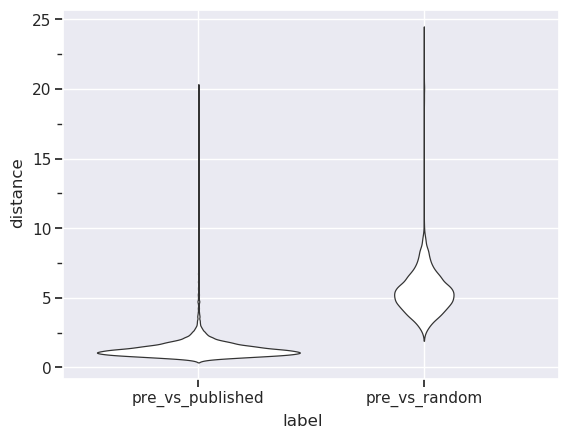

<ggplot: (8766765987469)>


In [18]:
g = (
    p9.ggplot(final_df)
    + p9.aes(x="label",y="distance")
    + p9.geom_violin()
    + p9.theme_seaborn()
)
g.save("output/biorxiv_article_distance.svg", dpi=500)
g.save("output/biorxiv_article_distance.png", dpi=500)
print(g)

# Logistic Regression bioRxiv preprints -> published PMC articles

In [19]:
model = LogisticRegressionCV(
    Cs=5, cv=10, random_state=100,
    penalty='elasticnet', solver='saga',
    l1_ratios=[0.1, 0.5, 0.8], verbose=2
)

In [20]:
training_dataset=(
    (
        biorxiv_published
        .dropna()
        .drop(["document", "published_doi", "pmcoa"], axis=1)
        -
        PMC_published
        .loc[biorxiv_published.index.tolist()]
        .dropna()
        .drop(["journal", "doi"], axis=1)
    )
    .assign(
        biorxiv_document=biorxiv_published.document.values,
        true_link=1
    )
)
training_dataset.head()

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299,biorxiv_document,true_link
PMC3585962,0.009064,-0.000823,-0.043496,0.061395,-0.123143,-0.000249,-0.003949,0.041907,-0.147803,-0.016656,...,-0.061430,-0.027216,0.063225,-0.003946,-0.159734,-0.054504,-0.026808,0.157170,000380_v1.xml,1
PMC3866385,-0.014535,-0.032770,-0.091847,0.034921,-0.120255,-0.051310,0.051741,0.039426,0.042513,-0.048026,...,-0.015112,-0.065617,-0.048685,-0.002945,-0.076812,-0.027028,-0.069290,-0.037080,000968_v1.xml,1
PMC3893193,-0.031233,-0.011245,-0.069128,0.033117,-0.140701,0.026707,0.001418,0.004358,-0.092967,-0.058892,...,0.003965,-0.135352,-0.015026,-0.054742,-0.122125,-0.061497,-0.017010,0.046472,001297_v2.xml,1
PMC3894166,0.014085,0.019877,-0.012712,-0.025261,-0.056740,-0.045135,0.018056,-0.004632,0.016861,0.010429,...,-0.015639,-0.087745,-0.006762,-0.045700,-0.015641,-0.039882,-0.045169,0.054353,000141_v1.xml,1
PMC3906208,-0.042190,0.006590,0.027834,-0.041590,-0.102061,0.005926,0.024729,-0.012260,-0.083363,-0.016308,...,-0.000110,-0.022076,-0.040525,-0.006139,-0.075874,-0.057256,0.037127,0.005347,000315_v1.xml,1


In [21]:
journals = (
    PMC_published
    .loc[biorxiv_published.index.tolist()]
    .query(f"journal in {PMC_off_published.journal.tolist()}")
    .journal
    .values
    .tolist()
)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
off_documents = (
    PMC_published
    .loc[biorxiv_published.index.tolist()]
    .query(f"journal in {PMC_off_published.journal.tolist()}")
    .index
    .tolist()
)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
training_dataset=(
    training_dataset
    .append(
        pd.DataFrame(
            biorxiv_published
            .loc[off_documents]
            .drop(["document", "published_doi", "pmcoa"], axis=1)
            .values 
            -
            PMC_off_published
            .iloc[list(map(lambda x: journal_mapper[x], journals))]
            .set_index("journal")
            .drop("document", axis=1)
            .values,
            columns=[f"feat_{idx}" for idx in range(300)]
        )
        .assign(true_link=-1)
    )
    .reset_index(drop=True)
    .drop("biorxiv_document", axis=1)
    .dropna()
)
training_dataset.head()

,feat_0,feat_1,feat_10,feat_100,feat_101,feat_102,feat_103,feat_104,feat_105,feat_106,...,feat_91,feat_92,feat_93,feat_94,feat_95,feat_96,feat_97,feat_98,feat_99,true_link
0,0.009064,-0.000823,0.023797,-0.046164,0.068757,-0.007358,-0.138738,-0.023491,0.056129,-0.112846,...,-0.038536,0.083080,0.004578,-0.042012,0.032515,-0.011364,0.026318,0.012145,-0.159117,1
1,-0.014535,-0.032770,-0.036483,0.032781,0.046944,-0.023940,-0.021749,-0.022915,0.025358,-0.000589,...,0.032973,0.091818,0.028400,0.028328,0.018053,-0.009167,-0.009260,0.057351,0.005674,1
2,-0.031233,-0.011245,-0.059920,-0.048860,0.046043,-0.099474,-0.123049,0.027652,0.089800,-0.089618,...,-0.032178,0.045831,-0.001445,-0.015592,0.033533,0.017725,-0.045323,0.002169,-0.068280,1
3,0.014085,0.019877,-0.096678,-0.092069,0.004430,-0.054995,-0.097458,-0.081546,-0.040478,-0.046230,...,0.046318,0.003453,-0.030622,-0.048440,-0.026411,-0.007505,0.017432,-0.041739,-0.053863,1
4,-0.042190,0.006590,-0.008508,0.003562,-0.020626,-0.004356,-0.047743,0.002162,0.006244,-0.029538,...,0.066111,0.031721,0.070657,0.015557,0.039802,0.012338,0.055734,0.021399,-0.013729,1


In [24]:
fit_model = model.fit(
    training_dataset.sample(frac=1, random_state=100).drop("true_link", axis=1), 
    training_dataset.sample(frac=1, random_state=100).true_link
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 2 seconds
convergence after 29 epochs took 3 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.8s remaining:    0.0s


convergence after 3 epochs took 0 seconds
convergence after 38 epochs took 5 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 3 epochs took 0 seconds
convergence after 45 epochs took 5 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 14 epochs took 2 seconds
convergence after 29 epochs took 3 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 3 epochs took 0 seconds
convergence after 38 epochs took 5 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 3 epochs took 0 seconds
convergence after 48 epochs took 6 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 13 epochs took 2 seconds
convergence after 30 epochs took 3 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 38 epochs took 5 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 45 epochs took 5 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 14 epochs took 1 seconds
convergence after 29 epochs took 4 seconds
max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds
convergence after 1 epochs took 1 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 38 epochs took 4 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 47 epochs took 6 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 14 epochs took 2 seconds
convergence after 29 epochs took 3 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 37 epochs took 5 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds
convergence after 1 epochs took 1 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 45 epochs took 5 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 13 epochs took 1 seconds
convergence after 30 epochs took 4 seconds
max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 37 epochs took 5 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 45 epochs took 5 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 13 epochs took 1 seconds
convergence after 29 epochs took 3 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 37 epochs took 5 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds
convergence after 1 epochs took 0 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 47 epochs took 5 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 13 epochs took 2 seconds
convergence after 29 epochs took 3 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 3 epochs took 0 seconds
convergence after 38 epochs took 5 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 3 epochs took 1 seconds
convergence after 44 epochs took 5 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 12 epochs took 1 seconds
convergence after 29 epochs took 3 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 3 epochs took 0 seconds
convergence after 38 epochs took 5 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 3 epochs took 0 seconds
convergence after 48 epochs took 6 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 13 epochs took 2 seconds
convergence after 29 epochs took 3 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 3 epochs took 0 seconds
convergence after 37 epochs took 5 seconds
max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


convergence after 3 epochs took 1 seconds
convergence after 46 epochs took 5 seconds
max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 10 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 11 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 18.8min finished


max_iter reached after 12 seconds


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [25]:
fit_model.scores_

{1: array([[[0.74456364, 0.49985503, 0.49985503],
         [0.87967527, 0.87039722, 0.86517831],
         [0.9162076 , 0.91591766, 0.91591766],
         [0.91823717, 0.91765729, 0.91823717],
         [0.91968687, 0.91968687, 0.91968687]],
 
        [[0.73528559, 0.49985503, 0.49985503],
         [0.87822557, 0.87213685, 0.86633807],
         [0.91504784, 0.91533778, 0.91591766],
         [0.91388808, 0.91359814, 0.91388808],
         [0.91301827, 0.91330821, 0.91330821]],
 
        [[0.74042923, 0.5       , 0.5       ],
         [0.86774942, 0.85962877, 0.85353828],
         [0.91328306, 0.91444316, 0.91444316],
         [0.91763341, 0.91763341, 0.91821346],
         [0.91821346, 0.91821346, 0.91821346]],
 
        [[0.73839907, 0.5       , 0.5       ],
         [0.88341067, 0.87238979, 0.86397912],
         [0.91647332, 0.91705336, 0.91676334],
         [0.91589327, 0.91589327, 0.91589327],
         [0.91589327, 0.91589327, 0.91589327]],
 
        [[0.74477958, 0.5       , 0.5       ]

In [28]:
import pickle
pickle.dump(fit_model, open("output/optimized_model.pkl", "wb"))

# Find bioRxiv unpublished ->  published PMC articles

In [26]:
biorxiv_unpublished = (
    biorxiv_journal_mapped_df
    .query("published_doi.isnull()")
    .drop(["published_doi", "pmcid", "pmcoa"], axis=1)
)
print(biorxiv_unpublished.shape)
biorxiv_unpublished.head()

(39706, 301)


,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
3,000091_v1.xml,-0.460216,-0.077183,-0.346650,0.354429,0.540097,-0.367523,-0.597944,-0.026886,0.658745,...,0.313261,-0.251339,0.563322,0.144810,-0.369955,-0.624727,0.338073,0.619281,-0.313213,-0.013729
9,000216_v1.xml,-0.878772,-0.382037,0.242107,0.273857,-0.240972,-0.685833,-0.162845,0.632005,0.432191,...,-0.514925,-0.151738,-0.114430,-0.211827,-0.670710,-0.032114,1.047945,0.428050,0.091200,-0.024027
11,000240_v1.xml,-0.222395,0.372372,-0.265261,-0.040393,-0.101332,0.127247,0.140201,-0.037639,0.263343,...,0.267328,0.475576,0.185293,-0.104871,-0.853241,-0.607207,0.262616,0.537938,-0.215396,0.115544
16,000349_v1.xml,-0.688957,-0.205284,-0.425503,0.061386,0.476985,0.069718,-0.302954,-0.282741,0.468321,...,0.115480,0.110121,0.320913,0.413017,-0.799646,-0.298769,0.460827,0.976833,-0.109842,-0.074529
17,000364_v1.xml,-0.780313,-0.241075,-0.444565,0.187437,0.243241,-0.068211,-0.142050,-0.248046,0.129683,...,0.085241,0.021038,0.397676,0.112086,-1.035499,-0.838363,0.181689,0.923590,-0.690641,-0.450603


In [27]:
PMC_unlinked = (
    pmc_journal_mapped_df
    .query(
        f"""
        document not in {
            biorxiv_published
            .reset_index()
            .pmcid
            .tolist()
        }
        """
    )
)
print(PMC_unlinked.shape)
PMC_unlinked.head()

(1834477, 303)


,journal,doi,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,Environ_Health,10.1186/1476-069X-5-22,PMC1552054,-0.428596,0.004477,-0.153677,0.059131,-0.394598,-0.066383,0.358798,...,-0.067994,0.033121,-0.077121,-0.433617,-1.111247,-0.405260,0.293903,0.613155,-0.500204,-0.214057
1,Environ_Health,10.1186/1476-069X-4-12,PMC1226148,-0.434013,-0.185516,-0.070654,0.488759,-0.280275,0.042681,0.116685,...,0.318905,-0.065244,0.159258,-0.380412,-0.665559,-0.485417,0.180982,0.523053,-0.485158,-0.251244
2,Environ_Health,10.1186/s12940-017-0316-3,PMC5635510,-0.248388,0.118660,-0.103008,0.267721,0.278939,-0.220584,0.089593,...,0.081127,-0.110091,-0.031617,-0.188741,-0.936947,-0.461118,0.618781,0.647195,-0.270240,-0.409643
3,Environ_Health,10.1186/1476-069X-10-46,PMC3125232,-0.507224,0.024099,-0.039696,-0.171992,0.371326,-0.137797,-0.202616,...,-0.218274,-0.022597,-0.028885,-0.250560,-1.140730,-0.568136,0.482088,0.899122,-0.250971,-0.592976
4,Environ_Health,10.1186/1476-069X-11-91,PMC3533997,-0.424435,0.175519,-0.048797,0.178023,-0.042913,-0.282377,0.317917,...,-0.111805,-0.262620,-0.187817,-0.463804,-1.308874,-0.352892,0.251982,0.550853,-0.659678,-0.614042


In [28]:
cutoff_score = (
    final_df
    .query("label=='pre_vs_random'")
    .distance
    .min()
)
cutoff_score

1.9184824531116913

In [29]:
chunksize=100
chunk_iterator = range(
    0, biorxiv_unpublished.shape[0], 
    chunksize
)

In [30]:
for idx, chunk in tqdm.tqdm(enumerate(chunk_iterator)):
    
    # Chunk the documents so memory doesn't break
    biorxiv_subset = (
        biorxiv_unpublished
        .iloc[chunk:chunk+chunksize]
    )
    
    # Calculate distances
    paper_distances = cdist(
        biorxiv_subset.drop(["document"], axis=1), 
        PMC_unlinked.drop(["journal", "document", "doi"], axis=1),
        'euclidean'
    )
    
    # Get elements less than threshold
    sig_indicies = np.where(paper_distances < cutoff_score)
    results = zip(
        sig_indicies[0],
        sig_indicies[1],
        paper_distances[paper_distances < cutoff_score]
    )
    
    # Map the results into records for pandas to parse
    results = list(
        map(
            lambda x: dict(
                document=biorxiv_subset.iloc[x[0]].document,
                pmcid=PMC_unlinked.iloc[x[1]].document,
                distance=x[2]
            ),
            results
        )
    )
    
    # There may be cases where there are no matches
    if len(results) > 0:
        # Generate pandas dataframe
        potential_matches_df = (
            biorxiv_journal_df[["document", "doi"]]
            .merge(
                pd.DataFrame
                .from_records(results)
            )
            .sort_values("distance")
        )
    
        # Write to file
        if idx == 0:
            potential_matches_df.to_csv(
                "output/potential_biorxiv_pmc_links.tsv", 
                sep="\t", index=False
            )

        else:
            potential_matches_df.to_csv(
                "output/potential_biorxiv_pmc_links.tsv", 
                sep="\t", index=False,
                mode="a", header=False
            )


398it [4:00:23, 36.24s/it]


# Bin Potential Matches

In [31]:
potential_matches_df = pd.read_csv(
    "output/potential_biorxiv_pmc_links.tsv",
    sep="\t"
)
potential_matches_df.head()

,document,doi,pmcid,distance
0,002097_v1.xml,10.1101/002097,PMC4404056,0.855655
1,000836_v1.xml,10.1101/000836,PMC4592070,0.857073
2,003129_v1.xml,10.1101/003129,PMC4866720,1.026857
3,000240_v1.xml,10.1101/000240,PMC4243381,1.130239
4,004291_v1.xml,10.1101/004291,PMC4650676,1.201887


In [32]:
potential_matches_df = (
    potential_matches_df
    .rename(index=str, columns={"doi":"biorxiv_doi"})
    .drop_duplicates(["document", "biorxiv_doi","pmcid"])
    .assign(
        pmcid_url=lambda x:(
            x
            .pmcid
            .apply(
                lambda paper: f"https://www.ncbi.nlm.nih.gov/pmc/{paper}"
            )
        ),
        biorxiv_doi_url=lambda x:(
            x
            .biorxiv_doi
            .apply(
                lambda paper: f"https://doi.org/{paper}"
            )
        )
    )
    
)
potential_matches_df.head()

,document,biorxiv_doi,pmcid,distance,pmcid_url,biorxiv_doi_url
0,002097_v1.xml,10.1101/002097,PMC4404056,0.855655,https://www.ncbi.nlm.nih.gov/pmc/PMC4404056,https://doi.org/10.1101/002097
1,000836_v1.xml,10.1101/000836,PMC4592070,0.857073,https://www.ncbi.nlm.nih.gov/pmc/PMC4592070,https://doi.org/10.1101/000836
2,003129_v1.xml,10.1101/003129,PMC4866720,1.026857,https://www.ncbi.nlm.nih.gov/pmc/PMC4866720,https://doi.org/10.1101/003129
3,000240_v1.xml,10.1101/000240,PMC4243381,1.130239,https://www.ncbi.nlm.nih.gov/pmc/PMC4243381,https://doi.org/10.1101/000240
4,004291_v1.xml,10.1101/004291,PMC4650676,1.201887,https://www.ncbi.nlm.nih.gov/pmc/PMC4650676,https://doi.org/10.1101/004291


In [33]:
distance_bins = np.squeeze(
    final_df
    .query("label=='pre_vs_published'")
    .describe()
    .loc[["25%", "50%", "75%"]]
    .values
)

distance_bins = np.append(
        [0.0],
        distance_bins,
)

distance_bins = np.append(
    distance_bins,
    (
        final_df
        .query("label=='pre_vs_random'")
        .distance
        .min()
    )   
)

distance_bins

array([0.        , 0.98019147, 1.22516676, 1.57598214, 1.91848245])

In [34]:
potential_matches_df = (
    potential_matches_df
    .assign(
        distance_bin=(
            pd.cut(
                potential_matches_df.distance,
                distance_bins,
                right=False,
                labels=[
                    "[0, 25%ile)",
                    "[25%ile, 50%ile)",
                    "[50%ile, 75%ile)",
                    "[75%, min(same-journal-no-known-link))"
                ]
            )
        )
    )
    [[
        "document", "biorxiv_doi", 
        "biorxiv_doi_url", "pmcid",
        "pmcid_url", "distance",
        "distance_bin"
    ]]
)

potential_matches_df.to_csv(
    "output/potential_biorxiv_pmc_links.tsv", 
    sep="\t", index=False
)

potential_matches_df.head()

,document,biorxiv_doi,biorxiv_doi_url,pmcid,pmcid_url,distance,distance_bin
0,002097_v1.xml,10.1101/002097,https://doi.org/10.1101/002097,PMC4404056,https://www.ncbi.nlm.nih.gov/pmc/PMC4404056,0.855655,"[0, 25%ile)"
1,000836_v1.xml,10.1101/000836,https://doi.org/10.1101/000836,PMC4592070,https://www.ncbi.nlm.nih.gov/pmc/PMC4592070,0.857073,"[0, 25%ile)"
2,003129_v1.xml,10.1101/003129,https://doi.org/10.1101/003129,PMC4866720,https://www.ncbi.nlm.nih.gov/pmc/PMC4866720,1.026857,"[25%ile, 50%ile)"
3,000240_v1.xml,10.1101/000240,https://doi.org/10.1101/000240,PMC4243381,https://www.ncbi.nlm.nih.gov/pmc/PMC4243381,1.130239,"[25%ile, 50%ile)"
4,004291_v1.xml,10.1101/004291,https://doi.org/10.1101/004291,PMC4650676,https://www.ncbi.nlm.nih.gov/pmc/PMC4650676,1.201887,"[25%ile, 50%ile)"
